## Task 2: Named Entity Recognition (NER)

In [9]:
# Imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from seqeval.metrics import classification_report

from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from collections import Counter
from wordcloud import WordCloud

import torch
from torch.utils.data import Dataset, DataLoader

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [2]:
# Read the CSV file containing named entity recognition (NER) data into a DataFrame
# The 'encoding="unicode_escape"' is used to handle any special or escaped characters in the file, like non-ASCII characters.
ner_df = pd.read_csv('datasets/ner_data.csv', encoding='unicode_escape')

# Display the first few rows of the dataset to inspect its structure
ner_df.head()

,sentence_id,word,tag
0,1,Patients,O
1,1,experienced,O
2,1,cough,B-SYMPTOM
3,1,after,O
4,1,administration,O


In [3]:
import re  # Import the regular expression module

# Define the drug-matching regex pattern that looks for tokens starting with "Drug" followed by a capital letter
drug_pattern = re.compile(r"^Drug[A-Z]$")

# Initialize an empty list to store the updated tags
new_tags = []

# Loop through the rows in the DataFrame, processing each word and its corresponding tag
for i, row in ner_df.iterrows():
    token, tag = row["word"], row["tag"]  # Extract the token and its current tag
    # If the tag is 'O' (outside any named entity) and the token matches the drug pattern, update the tag to 'B-DRUG'
    if tag == "O" and drug_pattern.match(token):
        new_tags.append("B-DRUG")  # Set the tag to 'B-DRUG' for tokens that match the pattern
    else:
        new_tags.append(tag)  # Otherwise, keep the original tag

# Update the 'tag' column in the DataFrame with the new tags
ner_df["tag"] = new_tags

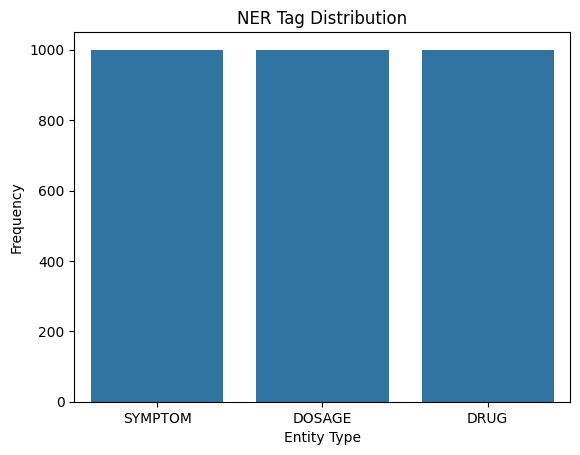

In [7]:
# Entity Type Frequency (Bar Chart)
entity_labels = [tag.split('-')[-1] for tag in ner_df['tag'] if tag != 'O']
label_counts = Counter(entity_labels)

sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("NER Tag Distribution")
plt.xlabel("Entity Type")
plt.ylabel("Frequency")
plt.show()

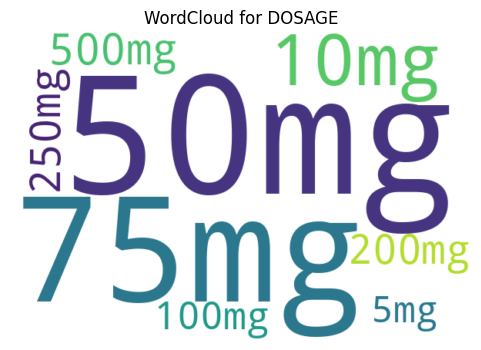

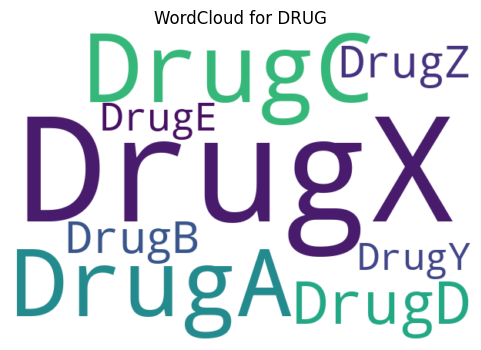

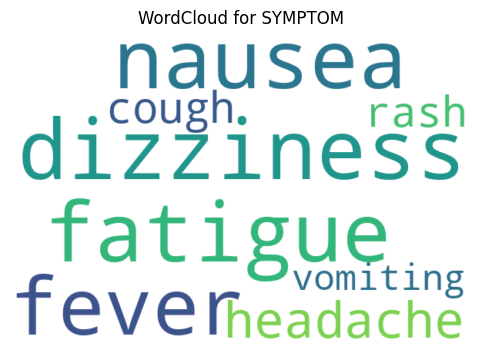

In [ ]:
for entity in set(entity_labels):
    words = ner_df[ner_df['tag'].str.endswith(entity)]['word'].values
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate(" ".join(words))
    
    plt.figure(figsize=(7, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {entity}")
    plt.show()


In [4]:
# Print the number of unique tags in the 'tag' column
print("Number of tags: {}".format(len(ner_df.tag.unique())))

# Calculate the frequency of each unique tag in the 'tag' column
frequencies = ner_df.tag.value_counts()

# Print the frequency of each tag (the number of occurrences of each unique tag)
print(frequencies)


Number of tags: 4
tag
O            5399
B-SYMPTOM    1000
B-DOSAGE     1000
B-DRUG       1000
Name: count, dtype: int64


In [5]:
# Create a dictionary that maps each unique tag to a unique integer ID (labels to IDs)
labels_to_ids = {v: k for k, v in enumerate(ner_df.tag.unique())}

# Create a dictionary that maps each integer ID back to its corresponding label (IDs to labels)
ids_to_labels = {k: v for k, v in enumerate(ner_df.tag.unique())}

# Print the dictionary that maps labels to IDs
print(labels_to_ids)

{'O': 0, 'B-SYMPTOM': 1, 'B-DOSAGE': 2, 'B-DRUG': 3}


In [6]:
# Create a new column called 'sentence' which groups the words by 'sentence_id'
# The 'groupby' operation groups the DataFrame by 'sentence_id', and the 'transform' function
# concatenates the words in each group into a single string (representing the sentence).
ner_df['sentence'] = ner_df[['sentence_id', 'word', 'tag']].groupby(['sentence_id'])['word'].transform(lambda x: ' '.join(x))

# Create a new column called 'word_labels' which groups the tags by 'sentence_id'
# Similar to the 'sentence' column, but here we concatenate the tags for each sentence
# The tags are separated by commas for each sentence.
ner_df['word_labels'] = ner_df[['sentence_id', 'word', 'tag']].groupby(['sentence_id'])['tag'].transform(lambda x: ','.join(x))

# Display the first few rows of the DataFrame to inspect the new columns
ner_df.head()


,sentence_id,word,tag,sentence,word_labels
0,1,Patients,O,Patients experienced cough after administratio...,"O,O,B-SYMPTOM,O,O,O,B-DOSAGE,O,B-DRUG"
1,1,experienced,O,Patients experienced cough after administratio...,"O,O,B-SYMPTOM,O,O,O,B-DOSAGE,O,B-DRUG"
2,1,cough,B-SYMPTOM,Patients experienced cough after administratio...,"O,O,B-SYMPTOM,O,O,O,B-DOSAGE,O,B-DRUG"
3,1,after,O,Patients experienced cough after administratio...,"O,O,B-SYMPTOM,O,O,O,B-DOSAGE,O,B-DRUG"
4,1,administration,O,Patients experienced cough after administratio...,"O,O,B-SYMPTOM,O,O,O,B-DOSAGE,O,B-DRUG"


In [17]:
duplicates = ner_df[ner_df.duplicated(subset=["sentence", "word_labels"])]
print(duplicates)

      sentence_id            word        tag  \
1               1     experienced          O   
2               1           cough  B-SYMPTOM   
3               1           after          O   
4               1  administration          O   
5               1              of          O   
...           ...             ...        ...   
8394         1000  post-treatment          O   
8395         1000            with          O   
8396         1000           100mg   B-DOSAGE   
8397         1000              of          O   
8398         1000           DrugA     B-DRUG   

                                               sentence  \
1     Patients experienced cough after administratio...   
2     Patients experienced cough after administratio...   
3     Patients experienced cough after administratio...   
4     Patients experienced cough after administratio...   
5     Patients experienced cough after administratio...   
...                                                 ...   
8394  Pati

In [7]:
# Find duplicate rows in the DataFrame based on the 'sentence' and 'word_labels' columns
# 'duplicated(subset=["sentence", "word_labels"])' returns a boolean series where True indicates a duplicate row
duplicates = ner_df[ner_df.duplicated(subset=["sentence", "word_labels"])]

# Print the duplicate rows to inspect them
print(duplicates)

# Select the 'sentence' and 'word_labels' columns from the DataFrame
# Drop any duplicate rows based on these two columns
# Reset the index to create a new sequential index for the resulting DataFrame
data = ner_df[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)


      sentence_id            word        tag  \
1               1     experienced          O   
2               1           cough  B-SYMPTOM   
3               1           after          O   
4               1  administration          O   
5               1              of          O   
...           ...             ...        ...   
8394         1000  post-treatment          O   
8395         1000            with          O   
8396         1000           100mg   B-DOSAGE   
8397         1000              of          O   
8398         1000           DrugA     B-DRUG   

                                               sentence  \
1     Patients experienced cough after administratio...   
2     Patients experienced cough after administratio...   
3     Patients experienced cough after administratio...   
4     Patients experienced cough after administratio...   
5     Patients experienced cough after administratio...   
...                                                 ...   
8394  Pati

In [8]:
# Set various hyperparameters for training and model configuration

MAX_LEN = 128  # Maximum length of the input sequences after tokenization. Longer sequences will be truncated, and shorter ones will be padded.
TRAIN_BATCH_SIZE = 4  # The batch size for training. This determines how many samples are processed in parallel during each training step.
VALID_BATCH_SIZE = 2  # The batch size for validation. Typically smaller than the training batch size.
EPOCHS = 1  # The number of training epochs. One epoch means one full pass through the entire training dataset.
LEARNING_RATE = 1e-05  # The learning rate for the optimizer. A smaller value means slower but more stable convergence.
MAX_GRAD_NORM = 10  # Maximum gradient norm for gradient clipping to avoid exploding gradients during training.

# Initialize the pre-trained BERT tokenizer (the uncased version)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')  # Tokenizer used to convert text into token ids for input into the model


In [9]:
'''
A tricky part of NER with BERT is that BERT relies on wordpiece tokenization, rather than word tokenization. This means that we should also define the labels at the wordpiece-level, rather than the word-level!
For example, if you have word like "Washington" which is labeled as "b-gpe", but it gets tokenized to "Wash", "##ing", "##ton", then one approach could be to handle this by only train the model on the tag labels for the first word piece token of a word (i.e. only label "Wash" with "b-gpe"). 
This is what was done in the original BERT paper, see Github discussion here.

Note that this is a design decision. 
You could also decide to propagate the original label of the word to all of its word pieces and let the model train on this. 
In that case, the model should be able to produce the correct labels for each individual wordpiece. 
This was done in this NER tutorial with BERT. 

Another design decision could be to give the first wordpiece of each word the original word label, and then use the label “X” for all subsequent subwords of that word. 
All of them seem to lead to good performance.

Below, we define a regular PyTorch dataset class (which transforms examples of a dataframe to PyTorch tensors). 
Here, each sentence gets tokenized, the special tokens that BERT expects are added, the tokens are padded or truncated based on the max length of the model, 
the attention mask is created and the labels are created based on the dictionary which we defined above. 
Word pieces that should be ignored have a label of -100 (which is the default ignore_index of PyTorch's CrossEntropyLoss).
'''
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        # get the sentence and word labels 
        sentence = self.df.sentence[index].strip().split()
        word_labels = self.df.word_labels[index].strip().split(',')
        # print(sentence, word_labels)

        # use tokenizer to encode sentence (includes padding/ truncation upto max length
        # BertTokenizerFast provides a handy 'return_offsets_mapping' functionality for individual tokens
        encoding = self.tokenizer(sentence, 
                                 is_split_into_words=True,
                                 return_offsets_mapping=True,
                                 padding='max_length',
                                 truncation=True,
                                 max_length = self.max_len)
        # print('--', encoding)

        # create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels]
        # print('++', labels)
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding['offset_mapping']), dtype=int) * -100
        # print('**', encoded_labels)

        # set only labels whose first offset position is 0 and second is not 0
        i = 0
        for idx, mapping in enumerate(encoding['offset_mapping']):
            if mapping[0]==0 and mapping[1]!=0:
                # overwrite label
                encoded_labels[idx] = labels[i]
                i += 1

        # turn everything into pytorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item
        
    
    def __len__(self):
        return self.len

In [10]:
# Define the size of the training set as 80% of the data
train_size = 0.8

# Split the 'data' DataFrame into a training dataset and a testing dataset
# The 'sample' function selects a random 80% of the data to create the training dataset
train_dataset = data.sample(frac=train_size, random_state=200)

# The remaining 20% of the data is used as the testing dataset, dropped from the 'train_dataset'
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)

# Reset the index of the training dataset to ensure it starts from 0
train_dataset = train_dataset.reset_index(drop=True)

# Print the shapes of the full dataset, training dataset, and testing dataset
print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# Create instances of the 'dataset' class for training and testing sets
# The 'dataset' class is assumed to handle tokenization and padding (e.g., with the tokenizer and MAX_LEN)
training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)


FULL Dataset: (825, 2)
TRAIN Dataset: (660, 2)
TEST Dataset: (165, 2)


In [11]:
# Define the parameters for the PyTorch DataLoader for training and testing

# For training, set the batch size, enable shuffling, and set the number of worker processes for loading data
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,  # The batch size for training
    'shuffle': True,  # Shuffle the dataset each epoch to ensure randomness in batches
    'num_workers': 0  # The number of worker processes to load data (0 means no parallel loading)
}

# For testing/validation, set the batch size, enable shuffling, and set the number of worker processes
test_params = {
    'batch_size': VALID_BATCH_SIZE,  # The batch size for validation/testing
    'shuffle': True,  # Shuffle the dataset during evaluation (optional, but often set to False during final test)
    'num_workers': 0  # The number of worker processes to load data
}

# Create DataLoader instances for training and testing datasets
# The DataLoader is used to efficiently load the data in batches during training and evaluation
training_loader = DataLoader(training_set, **train_params)  # DataLoader for the training set
testing_loader = DataLoader(testing_set, **test_params)  # DataLoader for the testing set


In [12]:
# Load the pre-trained BERT model for token classification
# 'bert-base-uncased' is the pre-trained BERT model (uncased version) for token classification tasks
# 'num_labels' is the number of distinct labels that the model will predict for each token in the input sequence
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [13]:
# Defining the training function for tuning the BERT model on the 80% of the dataset
def train(epoch):
    tr_loss, tr_accuracy = 0, 0  # Initialize training loss and accuracy
    nb_tr_examples, nb_tr_steps = 0, 0  # Initialize number of examples and steps
    tr_preds, tr_labels = [], []  # Initialize lists for predictions and true labels

    # Put model in training mode (important for enabling features like dropout)
    model.train()

    # Iterate over the training data (batches) from the DataLoader
    for idx, batch in enumerate(training_loader):
        # Extract inputs from the batch (input IDs, attention mask, and labels)
        ids = batch['input_ids']
        mask = batch['attention_mask']
        labels = batch['labels']

        # Zero gradients to prevent accumulation from previous steps
        optimizer.zero_grad()

        # Perform a forward pass through the model with the current batch
        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = outputs.loss  # Extract the loss value
        tr_logits = outputs.logits  # Extract the logits (raw predictions)

        # Update the cumulative loss
        tr_loss += loss.item()

        # Track the number of steps and examples processed
        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        # Print the training loss every 100 steps for monitoring
        if idx % 100 == 0:
            loss_step = tr_loss / nb_tr_steps
            print(f'Training loss per 100 training steps: {loss_step}')

        # Compute accuracy by comparing the predicted labels with the true labels
        flattened_targets = labels.view(-1)  # Flatten labels into a 1D tensor
        active_logits = tr_logits.view(-1, model.num_labels)  # Flatten logits into a 2D tensor
        flattened_predictions = torch.argmax(active_logits, axis=1)  # Get predicted labels by selecting the max logits

        # Mask out the padding tokens (-100 in the labels) when calculating accuracy
        active_accuracy = labels.view(-1) != -100  # Mask for valid (non-padding) labels

        # Select only the valid labels and predictions (ignoring padding tokens)
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        # Append the current labels and predictions to track accuracy across all steps
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        # Calculate accuracy for the current step and accumulate it
        tmp_tr_accuracy = accuracy_score(labels.numpy(), predictions.numpy())
        tr_accuracy += tmp_tr_accuracy

        # Perform gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # Perform a backward pass (compute gradients)
        loss.backward()

        # Update the model parameters using the optimizer
        optimizer.step()

    # Calculate average loss and accuracy for the entire epoch
    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps

    # Print the average training loss and accuracy for the epoch
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [16]:
# Loop through each epoch for training
# The number of epochs is determined by the EPOCHS variable
for epoch in range(EPOCHS):
    print(f'Training epoch: {epoch+1}')  # Print the current epoch number (starting from 1)
    
    # Call the 'train' function for each epoch, passing the current epoch number as an argument
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 1.4259635210037231
Training loss per 100 training steps: 0.18946062569681665
Training loss epoch: 0.11856740132312883
Training accuracy epoch: 0.963416597584055


In [17]:
# Define the evaluation function for the model
def valid(model, testing_loader):
    # Set the model to evaluation mode (disables dropout and other training-specific layers)
    model.eval()
    
    # Initialize variables to track the evaluation loss, accuracy, and number of examples processed
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    # No need to compute gradients during evaluation (to save memory and computation)
    with torch.no_grad():
        # Iterate through the batches of the testing data
        for idx, batch in enumerate(testing_loader):
            # Extract input IDs, attention mask, and labels from the batch
            ids = batch['input_ids']
            mask = batch['attention_mask']
            labels = batch['labels']
            
            # Pass the data through the model
            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs.loss  # Extract the loss value
            eval_logits = outputs.logits  # Extract the logits (raw predictions)

            # Accumulate the evaluation loss
            eval_loss += loss.item()

            # Increment the number of steps and examples processed
            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # Print the evaluation loss every 100 steps for monitoring
            if idx % 100 == 0:
                loss_step = eval_loss / nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # Compute evaluation accuracy
            flattened_targets = labels.view(-1)  # Flatten the labels (shape: batch_size * seq_len)
            active_logits = eval_logits.view(-1, model.num_labels)  # Flatten the logits (shape: batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1)  # Get predicted class labels (shape: batch_size * seq_len)
            
            # Only compute accuracy for valid tokens (non-padding tokens)
            active_accuracy = labels.view(-1) != -100  # Mask for valid (non-padding) labels

            # Select only the valid labels and predictions (ignoring padding tokens)
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            # Append the current labels and predictions for computing accuracy
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            # Compute accuracy for the current step and accumulate it
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    # Convert label IDs and prediction IDs back to label strings using the 'ids_to_labels' dictionary
    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    # Calculate the average evaluation loss and accuracy
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    # Print the final evaluation results
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    # Return the decoded labels and predictions
    return labels, predictions

In [18]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.0018305445555597544
Validation Loss: 0.001760661398644099
Validation Accuracy: 1.0


In [19]:
# Wrap the labels and predictions in a list to treat them as a single sequence (one sentence)
# This ensures the input is in the format expected by classification_report
labels_nested = [labels]
predictions_nested = [predictions]

# Generate and print the classification report for the entire dataset
print(classification_report(labels_nested, predictions_nested))

              precision    recall  f1-score   support

      DOSAGE       1.00      1.00      1.00       165
        DRUG       1.00      1.00      1.00       165
     SYMPTOM       1.00      1.00      1.00       165

   micro avg       1.00      1.00      1.00       495
   macro avg       1.00      1.00      1.00       495
weighted avg       1.00      1.00      1.00       495



In [20]:
import os  # Import the OS module for interacting with the operating system

# Define the directory where the model and tokenizer will be saved
directory = "./ner_model"

# Check if the directory exists, and if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the tokenizer's vocabulary (this includes the tokenizer's vocab and configuration)
# The vocabulary contains all the tokens the tokenizer can recognize
tokenizer.save_vocabulary(directory)

# Save the model weights and configuration files
# This saves the model's learned weights as well as configuration settings like model architecture
model.save_pretrained(directory)

# Print a message indicating that all files have been successfully saved
print('All files saved')

All files saved


In [21]:
import time

# Define a list of sentences for model inference
sentence = [
    "Patients were given 50mg of Aspirin and developed rash",
    "Volunteers were given 10mg of Melatonin and experienced dizziness",
    "Subjects were administered 100mg of Ibuprofen and reported nausea",
    "Elderly patients took 200mg of Metformin and developed muscle pain",
    "Participants were given 25mg of Antihistamine and showed signs of drowsiness"
]

# Loop over each sentence in the list
for line in sentence:
    # Tokenize the sentence into word pieces, including offsets for each token's position in the original sentence
    inputs = tokenizer(line.split(),
                       is_split_into_words=True,  # Indicate that the input is already split into words
                       return_offsets_mapping=True,  # Include token offsets for wordpiece boundaries
                       padding='max_length',  # Pad to the maximum length defined by MAX_LEN
                       truncation=True,  # Truncate sentences that exceed MAX_LEN
                       max_length=MAX_LEN,  # Set the maximum length for tokenized sequences
                       return_tensors="pt")  # Return PyTorch tensors for model input

    # Move tokenized inputs to the GPU (if available)
    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    
    # Start measuring time for the forward pass
    start = time.perf_counter()
    
    # Perform a forward pass through the model with the input tokens and attention mask
    outputs = model(ids, attention_mask=mask)
    
    # End time measurement for the forward pass
    end = time.perf_counter()

    # Extract the logits (raw predictions) from the model's output
    logits = outputs[0]

    # Reshape logits to (batch_size * seq_len, num_labels) for token-level prediction
    active_logits = logits.view(-1, model.num_labels)

    # Get the predicted labels by selecting the class with the highest logit for each token
    flattened_predictions = torch.argmax(active_logits, axis=1)

    # Convert token IDs back to tokens (wordpieces) using the tokenizer
    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    
    # Get the model's token-level predictions using the label-to-ID mapping
    token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
    
    # Combine the tokens with their predictions in a list of tuples
    wp_preds = list(zip(tokens, token_predictions))  # [(wordpiece, prediction), ...]

    # List to store the final predictions for the entire sentence
    prediction = []
    
    # Iterate through each wordpiece and its corresponding offset mapping to collect predictions
    for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
        # Only predictions for the first wordpiece of each token are relevant
        if mapping[0] == 0 and mapping[1] != 0:  # This condition checks if it's the first wordpiece
            prediction.append(token_pred[1])  # Append the predicted label for that word
        else:
            continue  # Skip non-first wordpieces

    # Print the original sentence (split into words)
    print(line.split())
    
    # Print the predictions for each word in the sentence
    print(prediction)

['Patients', 'were', 'given', '50mg', 'of', 'Aspirin', 'and', 'developed', 'rash']
['O', 'O', 'O', 'B-DOSAGE', 'O', 'O', 'O', 'O', 'B-SYMPTOM']
['Volunteers', 'were', 'given', '10mg', 'of', 'Melatonin', 'and', 'experienced', 'dizziness']
['O', 'O', 'O', 'B-DOSAGE', 'O', 'O', 'O', 'O', 'B-SYMPTOM']
['Subjects', 'were', 'administered', '100mg', 'of', 'Ibuprofen', 'and', 'reported', 'nausea']
['O', 'O', 'O', 'B-DOSAGE', 'O', 'O', 'O', 'O', 'B-SYMPTOM']
['Elderly', 'patients', 'took', '200mg', 'of', 'Metformin', 'and', 'developed', 'muscle', 'pain']
['O', 'O', 'O', 'B-DOSAGE', 'O', 'B-DRUG', 'O', 'O', 'O', 'B-SYMPTOM']
['Participants', 'were', 'given', '25mg', 'of', 'Antihistamine', 'and', 'showed', 'signs', 'of', 'drowsiness']
['O', 'O', 'O', 'B-DOSAGE', 'O', 'B-DRUG', 'O', 'O', 'O', 'O', 'B-SYMPTOM']
